# General Format of Python Cooking Session

Most recipes can be found via a quick google search. We're not trying to replace that.

Instead, we're going to go over some core recipes that are hard to reach with searches. For some recipes, if you've never heard of it before, you wouldn't know to search for it. Those are the ones we will focus on in these sessions.

For upcoming volunteers, we don't have to stick to the book. We probably won't even cover all the chapters.I would like to curate the recipes to be presented with you however if you plan on going up next!


# 1. Packing, Unpacking

In [43]:
# Unpack into variables
x, y = (1, 2)
x, (y, z) = (1, (2, 3))

In [45]:
# Unpack N elements from iterable with length > N
first, *middle, last = (1, 2, 3, 4, 5)

## Ignoring middle fields is a powerful pattern

In [46]:
line = "nobody:*:-2:-2:Unprivileged User:/var/empty:/usr/bin/false"

In [47]:
user, *fields, homedir, sh = line.split(":")

In [48]:
homedir

'/var/empty'

In [18]:
sh

'/usr/bin/false'

In [49]:
# Don't care about middle fields, throwaway
name, *_, (*_, year) = ('ACME', 50, 123.45, (12, 18, 2012))

In [22]:
name

'ACME'

In [23]:
year

2012

# 2. Defaultdict: Very Frequently Used

- Problem: Want to avoid dictionary value initialization for mutable values ex. lists, sets, dicts

In [51]:
# Without defaultdict
product_orders = {}
history = [
    ("customer_a", "product_1"), 
    ("customer_b", "product_2"), 
    ("customer_c", "product_1"),
]

for customer, product in history:
    # If doesn't exist, create list of customers
    if not product_orders.get(product):
        product_orders[product] = [customer]
    
    # If does exist, can append
    else:
        product_orders[product].append(customer)
        
product_orders

{'product_1': ['customer_a', 'customer_c'], 'product_2': ['customer_b']}

### Can do this much more easily with defaultdicts

In [52]:
# With defaultdict
from collections import defaultdict

product_orders = defaultdict(list)  # All values are an empty list by default
for customer, product in history:
    product_orders[product].append(customer)
    
product_orders

defaultdict(list,
            {'product_1': ['customer_a', 'customer_c'],
             'product_2': ['customer_b']})

In [55]:
# We can even have defaultdicts of custom datatypes!
from pydantic import BaseModel
from typing import Optional

class User(BaseModel):
    name: Optional[str]
        
users = defaultdict(User)

# No need to initialize empty instance! Automatically done:
users["rami"].name = "Rami"
users["rami"]

User(name='Rami')

### 3. Deque: Used, but not that often

- Useful for keeping last N results dynamically while iterating (ex. moving averages)

In [29]:
import matplotlib.pyplot as plt

In [58]:
from collections import deque
import matplotlib.pyplot as plt

daily_prices = [100, 104, 105, 110, 109, 101, 98, 96, 97, 95, 98, 99, 101, 102]

# Calculate moving average
tmp = deque(maxlen=3)
ma_3day = deque()

for price in daily_prices:
    tmp.append(price)
    ma_3day.append(sum(tmp)/3)

# Discard first two items: O(1) since double ended queue
_ = ma_3day.popleft()
_ = ma_3day.popleft()

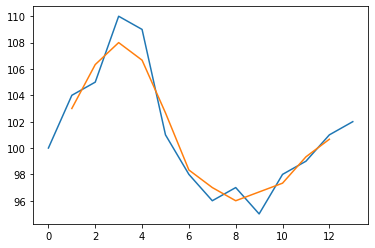

In [59]:
plt.plot(range(len(daily_prices)), daily_prices)
plt.plot(range(1, len(daily_prices) - 1), ma_3day)

Practically, I've mostly used it for graph searching

Ex. https://github.com/RamiAwar/packr/blob/bd4421806154d4cce361bee7817faf9e8a5e8ea0/packr/core.py#L189

In [56]:
def do_something(x):
    pass

In [60]:
nodes = deque([2, 1, 3])

graph = {
    1: [9],
    2: [3, 5],
}

while nodes:
    # First in, first out
    node = nodes.popleft()
    
    print(f"visiting {node}")
    
    if graph.get(node):
        nodes.extend(graph[node])

visiting 2
visiting 1
visiting 3
visiting 3
visiting 5
visiting 9


# 4. Heapq: Meh, rarely used

In [61]:
import heapq

portfolio = [
       {'name': 'IBM', 'shares': 100, 'price': 91.1},
       {'name': 'AAPL', 'shares': 50, 'price': 543.22},
       {'name': 'FB', 'shares': 200, 'price': 21.09},
       {'name': 'HPQ', 'shares': 35, 'price': 31.75},
       {'name': 'YHOO', 'shares': 45, 'price': 16.35},
       {'name': 'ACME', 'shares': 75, 'price': 115.65}
]

expensive_3 = heapq.nlargest(3, portfolio, key=lambda s: s["price"])
expensive_3

# Notice not sorted

[{'name': 'AAPL', 'shares': 50, 'price': 543.22},
 {'name': 'ACME', 'shares': 75, 'price': 115.65},
 {'name': 'IBM', 'shares': 100, 'price': 91.1}]

If populating on the fly, construct a heap and use `heappush()` and `heappop()` ex. PriorityQueue from book

# 5. Dictionary Tools

- Invert keys, values to operate on values

In [63]:
prices = {"a": 1, "b": 2, "c": -1, "d": 5}

min_price = min(zip(prices.values(), prices.keys()))
print(f"min_price = {min_price}")

prices_sorted = sorted(zip(prices.values(), prices.keys()))
prices_sorted

min_price = (-1, 'c')


[(-1, 'c'), (1, 'a'), (2, 'b'), (5, 'd')]

Personally I think this is unclear code as it assumes knowledge of sorted using the first element of tuples. The following is more Pythonic:

In [82]:
sorted(prices.items(), key=lambda x: x[1])

[('c', -1), ('a', 1), ('b', 2), ('d', 5)]

When doing these calculations, be aware that zip() creates an iterator that can only be consumed once. We will talk more about this in the amazing chapter 4: iterators, generators.

In [66]:
z = zip(prices.values(), prices.keys())

a = list(z)
b = list(z)

print(f"a: {a}\nb:{b}")

a: [(1, 'a'), (2, 'b'), (-1, 'c'), (5, 'd')]
b:[]


# 6. Don't be afraid of using generators

- 1.10: Remove duplicates from a sequence while maintaining order

In [71]:
from typing import List, Iterator

items: List[int] = [1, 2, 1, 5, 5, 3, 8, 1, 2, 8, 3, 5, 9]


def dedupe(items) -> Iterator[int]:
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

for item in dedupe(items):
    print(item

SyntaxError: unexpected EOF while parsing (4028681565.py, line 14)

### Why use generators not a list? Will be clearer in chapter 4!

Generators are lazy. They will not 'yield' their values until consumed essentially.



In [72]:
x = dedupe(items)
x

<generator object dedupe at 0x1105383c0>

In [74]:
x[1]

TypeError: 'generator' object is not subscriptable

In [75]:
next(x)

1

In [76]:
list(x)

[2, 5, 3, 8, 9]

In [11]:
list(x)

[]

# 7. Slices are first class citizens!

Avoid magic numbers where you can!

Hardcoded slices can be confusing. Use Python's built-in slice object instead.

In [77]:
import numpy as np

prices = np.array([1, 2, 3, 4, 5])
quantities = np.array([10, 12, 8, 1, 3])

first_3 = slice(0,3)

three_day_average = sum(prices[first_3] * quantities[first_3]) / 3.0
three_day_average

19.333333333333332

In [23]:
first_3.start, first_3.stop

(0, 3)

# 8. Counting, most common item and more

In [79]:
categories = ["a", "b", "a", "c", "d", "b", "b", "d", "j", "e", "s", "s", "a", "c", "g"]

from collections import Counter

Counter(categories).most_common(3)

[('a', 3), ('b', 3), ('c', 2)]

# 9. Lambda Alternatives when sorting

Also a tiny bit faster

In [80]:
from operator import attrgetter, itemgetter

# Attrgetter 

users = [User(name="Rami"), User(name="David"), User(name="Stojan"), User(name="Atul")]

In [81]:
%%timeit
max(users, key=attrgetter('name'))

277 ns ± 2.03 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [82]:
%%timeit
max(users, key=lambda user: user.name)

320 ns ± 1.51 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [83]:
# Itemgetter

users = [{"age": 10}, {"age": 20}, {"age": 3}, {"age": 4}]

max(users, key=itemgetter("age"))

{'age': 20}